In [1]:
import numpy as np
import tqdm
import statsmodels.tsa.stattools
import scipy.signal
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

In [3]:
#compute dependence of auc values on fraction of csd for fixed time length

In [4]:
T = 14000
n_steps_per_unit_time = 10
dt = 1/n_steps_per_unit_time
window_length = 700
n_windows = int(T/window_length)

In [5]:
n_parameter_settings = 100

np.random.seed(1)

l0s = np.random.uniform(0.3,0.5,n_parameter_settings)
th0s = np.random.uniform(0.5,4,n_parameter_settings)
thTs = np.random.uniform(0.5,4,n_parameter_settings)    
k0s = np.random.uniform(0.5,4,n_parameter_settings)
kTs = np.random.uniform(0.5,4,n_parameter_settings)

In [37]:
#linear ramp for kappa
def kappa(t,k0,kT,T):
    return (1-t/T)*k0 + t/T*kT

#linear ramp for theta
def theta(t,th0,thT,T):
    return (1-t/T)*th0 + t/T*thT


def ls(t,l0,T):
    return l0*np.sqrt(1-t/T)



def get_var(x,window_length):
    #get var of T-windows with length window length. Gives n_windows values
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var


def get_ar(x,window_length):
#x should have size T*steps_per_unit_time + 1
    ar = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2))[1]
    return ar

#ls version without convolution

def get_ls_k(x,noise,k0,kT,window_length,T):


    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    
    ls = np.full(n_windows,np.nan)



    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                #here window_length should be even

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]
        kappa_window = kappa(np.arange(i*window_length,(i+1)*window_length),k0,kT,T)                                                                               
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[n]*np.arange(0,window_length)) @ (noise_window*kappa_window)))**2 for n in range(int(window_length/2) - 1)])

        popt = scipy.optimize.curve_fit(fitfunction,
                                                frequencies, 
                                                np.log(estim_psd_xs_wn/estim_psd_xi_wn),
                                                p0=[1.0],
                                                bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

    return ls


In [30]:
def get_paths_decreasing_ls(l0,k0,kT,th0,thT,T):
    #simulate sample paths with euler method with decreasing ls 
    n_steps = T*n_steps_per_unit_time
    solve_ts = np.linspace(0,T,n_steps + 1)


    xs = np.zeros(n_steps+1)
    us = np.zeros(n_steps+1)

    #simulate us
    for i in tqdm.trange(n_steps):
        us[i+1] = np.exp(-theta(solve_ts[i],th0,thT,T)*dt)*us[i] + np.sqrt(1/(2*theta(solve_ts[i],th0,thT,T))*(1-np.exp(-2*theta(solve_ts[i],th0,thT,T)*dt)))*np.random.normal(0,1)

    for i in tqdm.trange(n_steps):
        xs[i+1] = xs[i] - ls(solve_ts[i],l0,T)*xs[i]*dt + kappa(solve_ts[i],k0,kT,T)*us[i]*dt

    xs_filtered = xs[::n_steps_per_unit_time]
    us_filtered = np.array([np.sum([us[i*n_steps_per_unit_time+j] for j in range(n_steps_per_unit_time)])*dt for i in range(T)])
    return xs_filtered, us_filtered



def get_paths_fix_l0(l0,k0,kT,th0,thT,T):
    #simulate sample paths with euler method with fix l0 value
    n_steps = T*n_steps_per_unit_time
    solve_ts = np.linspace(0,T,n_steps + 1)


    xs = np.zeros(n_steps+1)
    us = np.zeros(n_steps+1)

    #simulate us
    for i in tqdm.trange(n_steps):
        us[i+1] = np.exp(-theta(solve_ts[i],th0,thT,T)*dt)*us[i] + np.sqrt(1/(2*theta(solve_ts[i],th0,thT,T))*(1-np.exp(-2*theta(solve_ts[i],th0,thT,T)*dt)))*np.random.normal(0,1)

    for i in tqdm.trange(n_steps):
        xs[i+1] = xs[i] - l0*xs[i]*dt + kappa(solve_ts[i],k0,kT,T)*us[i]*dt

    xs_filtered = xs[::n_steps_per_unit_time]
    us_filtered = np.array([np.sum([us[i*n_steps_per_unit_time+j] for j in range(n_steps_per_unit_time)])*dt for i in range(T)])
    return xs_filtered, us_filtered

In [9]:
ind_series_var_decr_ls = np.zeros((n_parameter_settings,n_windows))
ind_series_ar_decr_ls = np.zeros((n_parameter_settings,n_windows))
ind_series_ls_decr_ls = np.zeros((n_parameter_settings,n_windows))

ind_series_var_fix_ls = np.zeros((n_parameter_settings,n_windows))
ind_series_ar_fix_ls = np.zeros((n_parameter_settings,n_windows))
ind_series_ls_fix_ls = np.zeros((n_parameter_settings,n_windows))

In [10]:
for i in tqdm.trange(n_parameter_settings):
    l0, th0, thT, k0, kT = l0s[i], th0s[i], thTs[i], k0s[i], kTs[i]
    
    xs_filtered_decr_ls, us_filtered = get_paths_decreasing_ls(l0, k0, kT, th0, thT)
    xs_filtered_fix_l0, us_filtered = get_paths_fix_l0(l0, k0, kT, th0, thT)

    ind_series_var_decr_ls[i,:] = get_var(xs_filtered_decr_ls)
    ind_series_ar_decr_ls[i,:] = get_ar(xs_filtered_decr_ls)
    ind_series_ls_decr_ls[i,:] = get_ls_k(xs_filtered_decr_ls,us_filtered,k0,kT)

    
    ind_series_var_fix_ls[i,:] = get_var(xs_filtered_fix_l0)
    ind_series_ar_fix_ls[i,:] = get_ar(xs_filtered_fix_l0)
    ind_series_ls_fix_ls[i,:] = get_ls_k(xs_filtered_fix_l0,us_filtered,k0,kT)

100%|██████████| 100/100 [09:52<00:00,  5.93s/it]


In [38]:
def get_kendall_taus(frac_data):
    #fracdata in 0.2,0.4,0.6,0.8,1
    n_windows_frac = int(n_windows*frac_data)

    reference = np.arange(n_windows_frac)
    kendall_taus = np.zeros((n_parameter_settings*2,3))
    
    for i in tqdm.trange(n_parameter_settings):

        kendall_taus[2*i,0] = kendalltau(reference,ind_series_var_decr_ls[i,:n_windows_frac])[0]
        kendall_taus[2*i,1] = kendalltau(reference,ind_series_ar_decr_ls[i,:n_windows_frac])[0]
        kendall_taus[2*i,2] = kendalltau(reference,-ind_series_ls_decr_ls[i,:n_windows_frac])[0]

            
        kendall_taus[2*i+1,0] = kendalltau(reference,ind_series_var_fix_ls[i,:n_windows_frac])[0]
        kendall_taus[2*i+1,1] = kendalltau(reference,ind_series_ar_fix_ls[i,:n_windows_frac])[0]
        kendall_taus[2*i+1,2] = kendalltau(reference,-ind_series_ls_fix_ls[i,:n_windows_frac])[0]

    return kendall_taus

In [27]:
def get_aucs_varying_frac(fracs,n_thresholds):
    #fracs should be 0.2,0.4,0.6,0.8,1

    aucs = np.zeros((len(fracs),3))      #3 indicators

    for i in tqdm.trange(len(fracs)):
        kendall_taus = get_kendall_taus(fracs[i])

        kendall_taus_decreasing_ls_var = kendall_taus[::2,0]
        kendall_taus_decreasing_ls_ar = kendall_taus[::2,1]
        kendall_taus_decreasing_ls_ls = kendall_taus[::2,2]


        kendall_taus_fix_l0_var = kendall_taus[1::2,0]
        kendall_taus_fix_l0_ar = kendall_taus[1::2,1]
        kendall_taus_fix_l0_ls = kendall_taus[1::2,2]


        #get ROC curves

        thresholds = np.linspace(1,-1,n_thresholds)

        true_positives = np.zeros((n_thresholds,3))
        false_positives = np.zeros((n_thresholds,3))


        for j in tqdm.trange(n_thresholds):

            true_positives[j,0] = np.mean(kendall_taus_decreasing_ls_var > thresholds[j])
            true_positives[j,1] = np.mean(kendall_taus_decreasing_ls_ar >  thresholds[j])
            true_positives[j,2] = np.mean(kendall_taus_decreasing_ls_ls >  thresholds[j])

            false_positives[j,0] = np.mean(kendall_taus_fix_l0_var >  thresholds[j])
            false_positives[j,1] = np.mean(kendall_taus_fix_l0_ar >  thresholds[j])
            false_positives[j,2] = np.mean(kendall_taus_fix_l0_ls >  thresholds[j])


        
        #approximate AUC values
        var_fp_x = np.concatenate((np.array([0]),false_positives[:,0][1:]-false_positives[:,0][:-1]))
        ac_fp_x = np.concatenate((np.array([0]),false_positives[:,1][1:]-false_positives[:,1][:-1]))
        ROSA_fp_x = np.concatenate((np.array([0]),false_positives[:,2][1:]-false_positives[:,2][:-1]))

        auc_var = np.round(np.dot(var_fp_x,true_positives[:,0]),2)
        auc_ac = np.round(np.dot(ac_fp_x,true_positives[:,1]),2)
        auc_ls = np.round(np.dot(ROSA_fp_x,true_positives[:,2]),2)

        aucs[i,:] = np.array([auc_var,auc_ac,auc_ls])


    return aucs


In [41]:
fracs = np.array([0.2,0.4,0.6,0.8,1])
aucs = get_aucs_varying_frac(np.array([0.2,0.4,0.6,0.8,1]),1001)

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


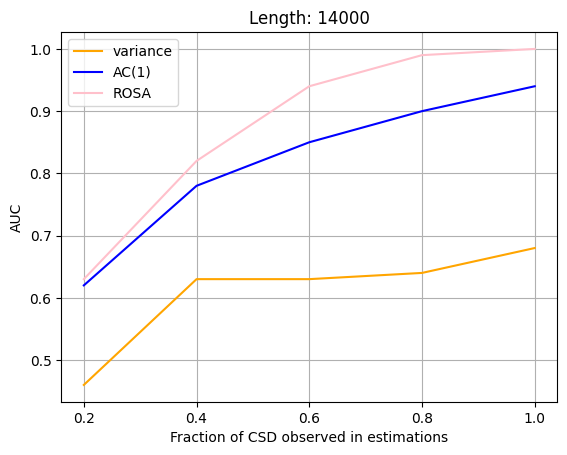

In [48]:
fig, ax = plt.subplots()

ax.plot(fracs,aucs[:,0],color='orange',label='variance')
ax.plot(fracs,aucs[:,1],color='blue',label='AC(1)')
ax.plot(fracs,aucs[:,2],color='pink',label='ROSA')


ax.set_xlabel('Fraction of CSD observed in estimations')
ax.set_xticks(fracs)

ax.set_ylabel('AUC')
ax.set_title('Length: 14000')

ax.grid(True)
ax.legend()


In [49]:
#compute dependence of auc values on time length for fixed fraction of csd

In [50]:
n_steps_per_unit_time = 10
dt = 1/n_steps_per_unit_time
n_windows = 20
n_windows_frac = int(n_windows*0.6)
reference = np.arange(n_windows_frac)            

In [51]:
n_parameter_settings = 30

np.random.seed(2)

l0s = np.random.uniform(0.3,0.5,n_parameter_settings)
th0s = np.random.uniform(0.5,4,n_parameter_settings)
thTs = np.random.uniform(0.5,4,n_parameter_settings)    
k0s = np.random.uniform(0.5,4,n_parameter_settings)
kTs = np.random.uniform(0.5,4,n_parameter_settings)

In [52]:
def get_aucs_varying_time_length(Ts,n_thresholds):

    aucs = np.zeros((len(Ts),3))                                                                           

    for j in tqdm.trange(len(Ts)):

        T = int(Ts[j])
        window_length = int(T/n_windows)
    
        kendall_taus = np.zeros((n_parameter_settings*2,3))

        for i in tqdm.trange(n_parameter_settings):
            l0, th0, thT, k0, kT = l0s[i], th0s[i], thTs[i], k0s[i], kTs[i]
            
            xs_filtered_decr_ls, us_filtered = get_paths_decreasing_ls(l0, k0, kT, th0, thT,T)
            xs_filtered_fix_l0, us_filtered = get_paths_fix_l0(l0, k0, kT, th0, thT,T)

            var_xs_decr_ls = get_var(xs_filtered_decr_ls,window_length)
            ar_xs_decr_ls = get_ar(xs_filtered_decr_ls,window_length)
            ls_xs_decr_ls = get_ls_k(xs_filtered_decr_ls,us_filtered,k0,kT,window_length,T)

            kendall_taus[2*i,0] = kendalltau(reference,var_xs_decr_ls[:n_windows_frac])[0]
            kendall_taus[2*i,1] = kendalltau(reference,ar_xs_decr_ls[:n_windows_frac])[0]
            kendall_taus[2*i,2] = kendalltau(reference,-ls_xs_decr_ls[:n_windows_frac])[0]

            
            var_xs_fix_l0 = get_var(xs_filtered_fix_l0,window_length)
            ar_xs_fix_l0 = get_ar(xs_filtered_fix_l0,window_length)
            ls_xs_fix_l0 = get_ls_k(xs_filtered_fix_l0,us_filtered,k0,kT,window_length,T)

            
            kendall_taus[2*i+1,0] = kendalltau(reference,var_xs_fix_l0[:n_windows_frac])[0]
            kendall_taus[2*i+1,1] = kendalltau(reference,ar_xs_fix_l0[:n_windows_frac])[0]
            kendall_taus[2*i+1,2] = kendalltau(reference,-ls_xs_fix_l0[:n_windows_frac])[0]


        kendall_taus_decreasing_ls_var = kendall_taus[::2,0]
        kendall_taus_decreasing_ls_ar = kendall_taus[::2,1]
        kendall_taus_decreasing_ls_ls = kendall_taus[::2,2]


        kendall_taus_fix_l0_var = kendall_taus[1::2,0]
        kendall_taus_fix_l0_ar = kendall_taus[1::2,1]
        kendall_taus_fix_l0_ls = kendall_taus[1::2,2]

                
        thresholds = np.linspace(1,-1,n_thresholds)

        true_positives = np.zeros((n_thresholds,3))
        false_positives = np.zeros((n_thresholds,3))


        for i in tqdm.trange(n_thresholds):

            true_positives[i,0] = np.mean(kendall_taus_decreasing_ls_var > thresholds[i])
            true_positives[i,1] = np.mean(kendall_taus_decreasing_ls_ar >  thresholds[i])
            true_positives[i,2] = np.mean(kendall_taus_decreasing_ls_ls >  thresholds[i])

            false_positives[i,0] = np.mean(kendall_taus_fix_l0_var >  thresholds[i])
            false_positives[i,1] = np.mean(kendall_taus_fix_l0_ar >  thresholds[i])
            false_positives[i,2] = np.mean(kendall_taus_fix_l0_ls >  thresholds[i])


        #compute AUC values
        var_fp_x = np.concatenate((np.array([0]),false_positives[:,0][1:]-false_positives[:,0][:-1]))
        ac_fp_x = np.concatenate((np.array([0]),false_positives[:,1][1:]-false_positives[:,1][:-1]))
        ROSA_fp_x = np.concatenate((np.array([0]),false_positives[:,2][1:]-false_positives[:,2][:-1]))

        auc_var = np.round(np.dot(var_fp_x,true_positives[:,0]),2)
        auc_ac = np.round(np.dot(ac_fp_x,true_positives[:,1]),2)
        auc_ls = np.round(np.dot(ROSA_fp_x,true_positives[:,2]),2)

        aucs[j,:] = np.array([auc_var,auc_ac,auc_ls])


    return aucs

In [53]:
Ts = np.linspace(5,30,6)*1000
aucs_var_time_length = get_aucs_varying_time_length(Ts,1001)

  0%|          | 0/6 [00:00<?, ?it/s]



100%|██████████| 50000/50000 [00:00<00:00, 138141.39it/s]


100%|██████████| 50000/50000 [00:00<00:00, 316788.90it/s]




100%|██████████| 50000/50000 [00:00<00:00, 130035.86it/s]

100%|██████████| 50000/50000 [00:00<00:00, 625173.87it/s]

100%|██████████| 20/20 [00:00<00:00, 6504.81it/s]

100%|██████████| 20/20 [00:00<00:00, 2500.33it/s]



100%|██████████| 20/20 [00:00<00:00, 85.06it/s]

100%|██████████| 20/20 [00:00<00:00, 4001.05it/s]

100%|██████████| 20/20 [00:00<00:00, 3934.99it/s]


100%|██████████| 20/20 [00:00<00:00, 96.66it/s] 




100%|██████████| 50000/50000 [00:00<00:00, 132181.42it/s]


100%|██████████| 50000/50000 [00:00<00:00, 265507.99it/s]





100%|██████████| 50000/50000 [00:00<00:00, 115471.26it/s]


100%|██████████| 50000/50000 [00:00<00:00, 467896.00it/s]

100%|██████████| 20/20 [00:00<00:00, 10003.11it/s]

100%|██████████| 20/20 [00:00<00:00, 3310.29it/s]


100%|██████████| 20/20 [00:00<00:00, 106.47it/s]

100%|█████████

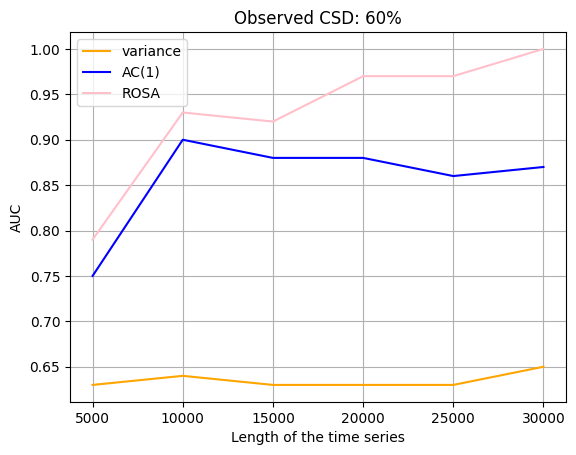

In [56]:
fig, ax = plt.subplots()

ax.plot(Ts,aucs_var_time_length[:,0],color='orange',label='variance')
ax.plot(Ts,aucs_var_time_length[:,1],color='blue',label='AC(1)')
ax.plot(Ts,aucs_var_time_length[:,2],color='pink',label='ROSA')


ax.set_xlabel('Length of the time series')
ax.set_xticks(Ts)

ax.set_ylabel('AUC')
ax.set_title('Observed CSD: 60%')

ax.grid(True)
ax.legend()